<a href="https://colab.research.google.com/github/maria-jahan20/Teeth-detection-using-VLM/blob/main/Florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installation

In [27]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Imports

In [28]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools
import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

##Dataset Load



In [29]:
rf = Roboflow(api_key="fwZ8YmD6kXjTnpU7rfQO")
project = rf.workspace("teethsegmentation").project("final_dataset-tznt6")
version = project.version(6)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...


##Florence-2 Base model

In [32]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

##Dataset class

In [33]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

##DataLoader for train and validation set

In [34]:
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)
test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

##LORA set up


In [35]:
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


##Empty cache for more storage

In [36]:
torch.cuda.empty_cache()

##Inference code on validation dataset


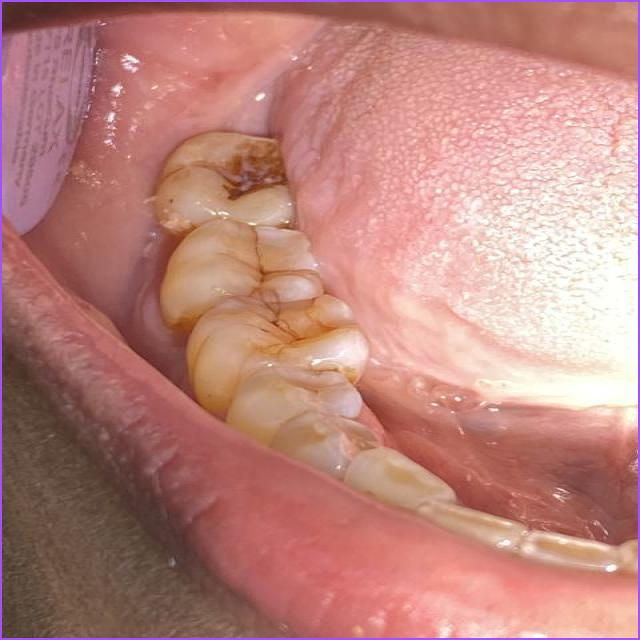
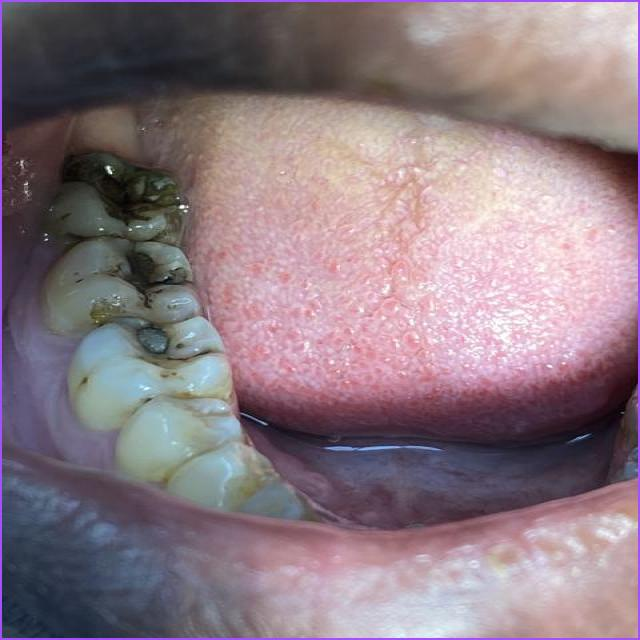
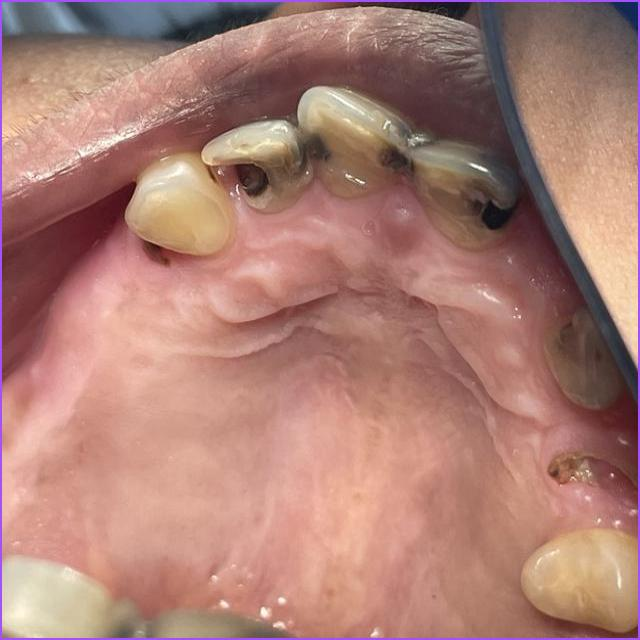
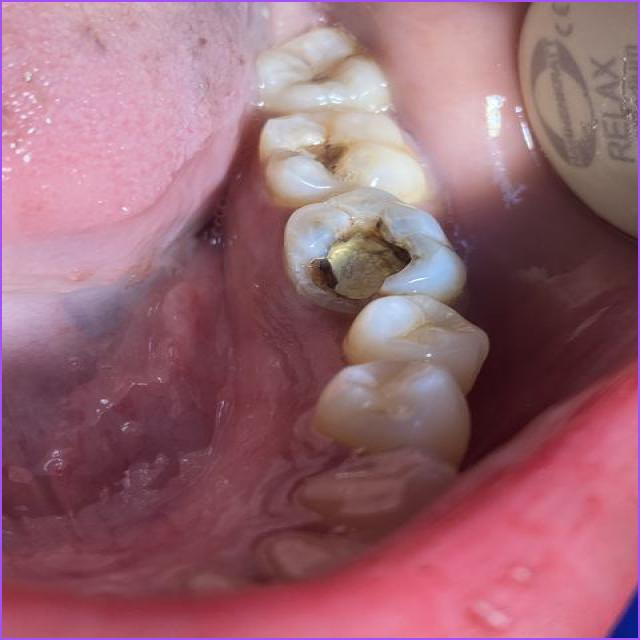

In [37]:
def render_inline(image: Image.Image, resize=(256, 256)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to render model responses')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(256, 256))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

In [38]:
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.0):
        """
        Initialize EarlyStopping.

        Args:
            patience (int): Number of epochs to wait for improvement.
            min_delta (float): Minimum change in validation loss to be considered an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def __call__(self, current_loss):
        """
        Check if training should stop.

        Args:
            current_loss (float): Current validation loss.
        """
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


##Preprocessing training set before running epochs

In [39]:
def train_model(train_loader, val_loader, model, processor, epochs=20, lr=5e-6, patience=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Early Stopping Check
        early_stopping(avg_val_loss)
        if early_stopping.should_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

        # Save Model
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


##Epochs

In [40]:
%%time

EPOCHS = 20
LR = 5e-5

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

Training Epoch 1/20: 100%|██████████| 86/86 [02:25<00:00,  1.69s/it]


Average Training Loss: 4.069222182728524


Validation Epoch 1/20: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


Average Validation Loss: 3.1320016043526784


Training Epoch 2/20: 100%|██████████| 86/86 [02:29<00:00,  1.74s/it]


Average Training Loss: 1.8720078995061475


Validation Epoch 2/20: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Average Validation Loss: 3.1070621013641357


Training Epoch 3/20: 100%|██████████| 86/86 [02:29<00:00,  1.74s/it]


Average Training Loss: 1.7327172271040983


Validation Epoch 3/20: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Average Validation Loss: 3.104104791368757


Training Epoch 4/20: 100%|██████████| 86/86 [02:29<00:00,  1.74s/it]


Average Training Loss: 1.5779111198214597


Validation Epoch 4/20: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Average Validation Loss: 3.1235482692718506


Training Epoch 5/20: 100%|██████████| 86/86 [02:29<00:00,  1.74s/it]


Average Training Loss: 1.4875590004200159


Validation Epoch 5/20: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

Average Validation Loss: 3.1275937216622487
Early stopping triggered at epoch 5.
CPU times: user 12min 17s, sys: 31.1 s, total: 12min 48s
Wall time: 12min 53s


##Using Regex for extract classes

In [41]:
import re

PATTERN = r'(\d)<loc_'
suffix = "0<loc_307><loc_227><loc_448><loc_316>3<loc_248><loc_320><loc_307><loc_383>1<loc_388><loc_412><loc_429><loc_438>"
matches = re.findall(PATTERN, suffix)
print(matches)


['0', '3', '1']


In [42]:
def extract_classes(dataset: DetectionDataset):
    """
    Extract unique class labels from the dataset.
    """
    class_set = set()
    for i in range(len(dataset.dataset)):
        _, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)  # Use the correct regex
        class_set.update(classes)
    return sorted(class_set)


##Extracting classes after training

In [43]:
CLASSES = extract_classes(train_dataset)
print(CLASSES)

['0', '1', '2', '3', '4']


##Prediction code

In [44]:
targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    # Generate predictions
    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Process predictions
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))  # Set dummy confidence scores

    # Process targets
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([
        CLASSES.index(class_name) if class_name in CLASSES else -1
        for class_name in target['class_name']
    ])
    valid_indices = target.class_id != -1  # Filter invalid classes
    target = target[valid_indices]

    # Append to lists
    targets.append(target)
    predictions.append(prediction)


##Mean average precision calculation

In [45]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.04
map50: 0.09
map75: 0.01


##Confusion matrix

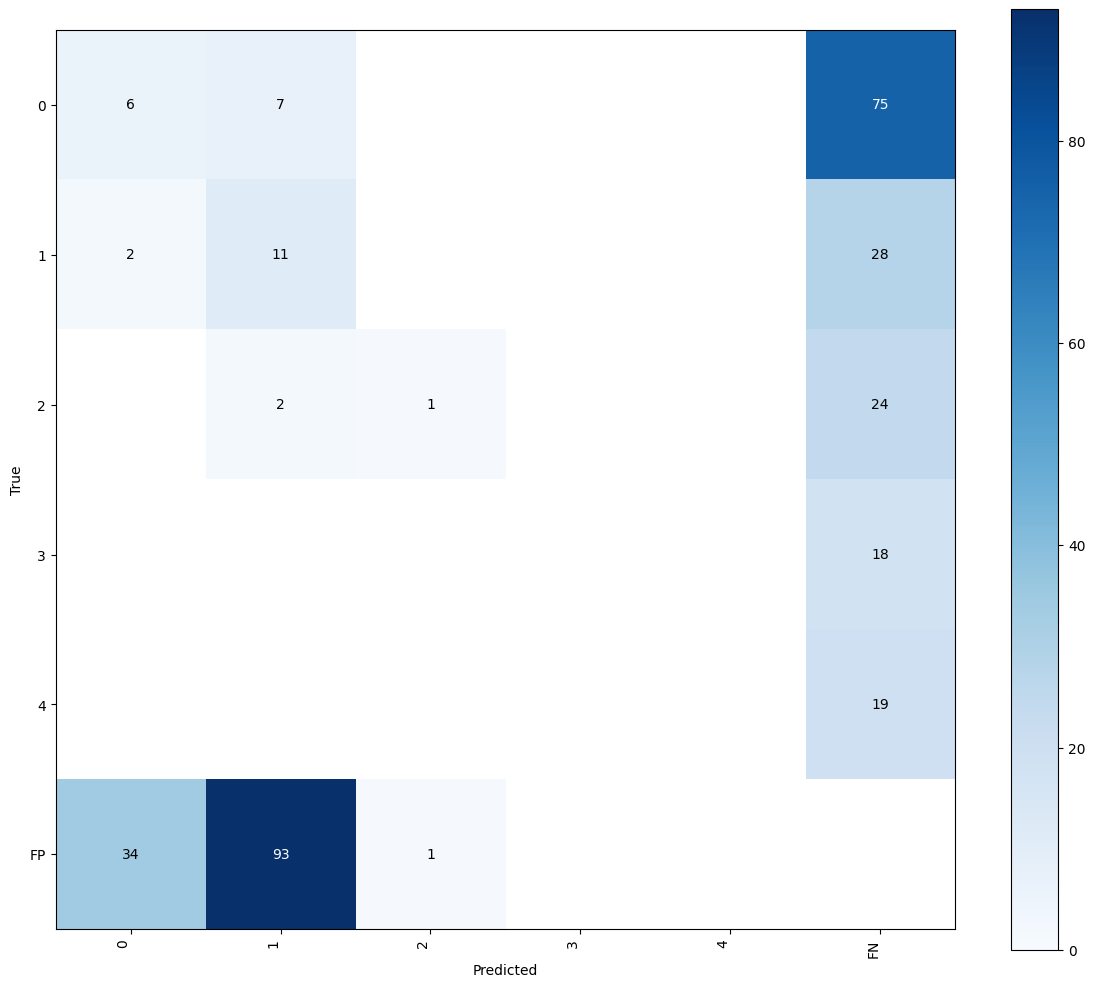

In [46]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

##Test fune tuned model on a random image from test set

In [47]:
EXAMPLE_IMAGE_PATH = "/content/final_dataset-6/test/intraoral_lower-1-_JPEG.rf.e5896401bd771f8b42d3b4d25bd0ea38.jpg"

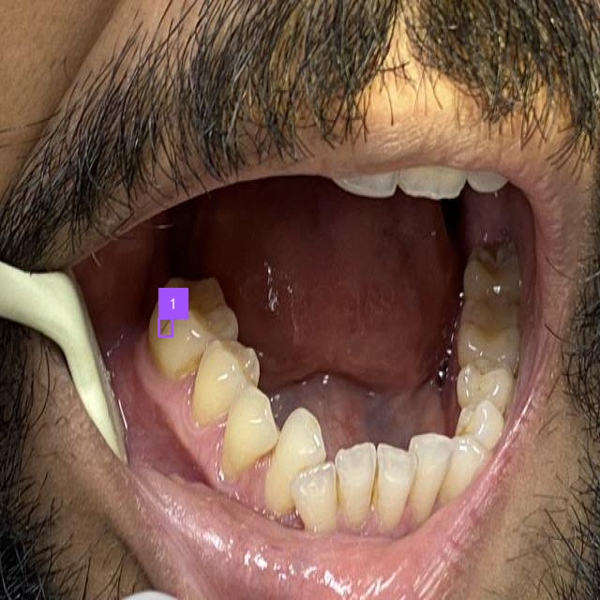

In [48]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image